In [1]:
## Cell 1: Setup and Import Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os # <-- THIS LINE FIXES THE ERROR

print("✅ Libraries imported successfully.")
print(f"TensorFlow Version: {tf.__version__}")

✅ Libraries imported successfully.
TensorFlow Version: 2.20.0


In [2]:
## Cell 2: Configuration and Hyperparameters

# --- Dataset File Paths ---
# !! Make sure these CSV files are in the same directory as your notebook !!
file_paths = {
    'csic': 'csic_2010.csv',
    'sqli': 'SQL_Injection_Dataset.csv',
    'xss': 'XSS_dataset.csv',
    'url': 'malicious_urls.csv'
}

# --- Model Hyperparameters ---
# Vocabulary size: The maximum number of unique characters to consider.
MAX_FEATURES = 10000
# Sequence length: The fixed length for all input sequences. Longer ones are truncated, shorter ones are padded.
MAX_LEN = 250
# Embedding dimension: The size of the dense vector for each character.
EMBEDDING_DIM = 128
# GRU units: The number of neurons in the GRU layer, representing the model's memory capacity.
GRU_UNITS = 128

# --- Training Parameters ---
BATCH_SIZE = 256
EPOCHS = 5 # Start with 5; you can increase this for potentially better performance.

print("✅ Configuration loaded.")

✅ Configuration loaded.


In [4]:
## Cell 3: Load Data and Split First, Then Preprocess (FIXED - No Data Leakage)

# First, try to load the master dataset
df_master = None
try:
    # Try to load the prepared dataset first
    master_dataset_path = 'prepared_dataset/master_web_attack_dataset.csv'
    if os.path.exists(master_dataset_path):
        print(f"\n🔄 Loading prepared master dataset from {master_dataset_path}...")
        df_master = pd.read_csv(master_dataset_path)
        print(f"✅ Master dataset loaded successfully!")
    else:
        # If prepared dataset doesn't exist, load and combine individual datasets
        print("\n🔄 Loading and processing individual datasets...")
        df_csic = pd.read_csv(file_paths['csic'])
        df_sqli = pd.read_csv(file_paths['sqli'])
        df_xss = pd.read_csv(file_paths['xss'])
        df_url = pd.read_csv(file_paths['url'])
        print("... all datasets loaded successfully.")

        # Standardize CSIC 2010
        df1 = df_csic[['content', 'classification']].copy()
        df1.rename(columns={'content': 'payload', 'classification': 'label'}, inplace=True)
        df1['label'] = df1['label'].apply(lambda x: 1 if str(x).lower() == 'anomalous' else 0)

        # Standardize SQL Injection
        df2 = df_sqli[['Query', 'Label']].copy()
        df2.rename(columns={'Query': 'payload', 'Label': 'label'}, inplace=True)

        # Standardize Cross-Site Scripting (XSS)
        df3 = df_xss[['Sentence', 'Label']].copy()
        df3.rename(columns={'Sentence': 'payload', 'Label': 'label'}, inplace=True)

        # Standardize Malicious URLs
        df4 = df_url[['url', 'type']].copy()
        df4.rename(columns={'url': 'payload', 'type': 'label'}, inplace=True)
        df4['label'] = df4['label'].apply(lambda x: 0 if x == 'benign' else 1)

        # Combine, Clean, and Shuffle
        df_combined = pd.concat([df1, df2, df3, df4], ignore_index=True)
        df_combined.dropna(inplace=True)
        df_combined = df_combined[df_combined['payload'].astype(str).str.len() > 1]
        df_master = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

        print("\n--- ✅ Master Dataset Created Successfully ---")
        
        # Save the dataset for future use
        os.makedirs('prepared_dataset', exist_ok=True)
        df_master.to_csv(master_dataset_path, index=False)
        print(f"\n💾 Master dataset saved to: '{master_dataset_path}'")

except (FileNotFoundError, KeyError) as e:
    print(f"\n❌ ERROR during data preparation: {e}")
    print("Please check that all CSV files exist and that the column names are correct.")

if df_master is not None and not df_master.empty:
    print("\n🔄 Splitting data into training and testing sets FIRST...")
    
    # Extract raw payloads and labels from the master dataframe
    payloads_raw = df_master['payload'].astype(str).values
    labels_raw = df_master['label'].values
    
    # 1. FIRST: Split the raw data before any preprocessing
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
        payloads_raw, labels_raw,
        test_size=0.2,  # Use 20% of the data for testing
        random_state=42,  # For reproducible results
        stratify=labels_raw  # Maintain class distribution
    )
    
    print(f"Raw training samples: {len(X_train_raw):,}")
    print(f"Raw testing samples:  {len(X_test_raw):,}")
    
    print("\n🔄 Preprocessing data: Converting text to numerical sequences...")
    
    # 2. SECOND: Fit tokenizer ONLY on training data to prevent data leakage
    tokenizer = Tokenizer(num_words=MAX_FEATURES, char_level=True, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train_raw)  # ← CRITICAL FIX: Only fit on training data
    
    # 3. Transform both training and testing data using the fitted tokenizer
    X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
    X_test_seq = tokenizer.texts_to_sequences(X_test_raw)
    
    # 4. Pad sequences to ensure all have the same length
    X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN)
    X_test = pad_sequences(X_test_seq, maxlen=MAX_LEN)
    
    # Convert labels to numpy arrays
    y_train = np.asarray(y_train_raw)
    y_test = np.asarray(y_test_raw)
    
    print(f"Training tensor shape (X_train): {X_train.shape}")
    print(f"Training tensor shape (y_train): {y_train.shape}")
    print(f"Testing tensor shape (X_test): {X_test.shape}")
    print(f"Testing tensor shape (y_test): {y_test.shape}")
    
    # Store the raw test data for later use in prediction function
    X_test_raw_stored = X_test_raw
    
else:
    print("Skipping preprocessing because the master dataframe was not created successfully.")


🔄 Loading prepared master dataset from prepared_dataset/master_web_attack_dataset.csv...
✅ Master dataset loaded successfully!

🔄 Splitting data into training and testing sets FIRST...
Raw training samples: 570,914
Raw testing samples:  142,729

🔄 Preprocessing data: Converting text to numerical sequences...
Training tensor shape (X_train): (570914, 250)
Training tensor shape (y_train): (570914,)
Testing tensor shape (X_test): (142729, 250)
Testing tensor shape (y_test): (142729,)


In [5]:
## Cell 4: Train-Test Split Already Done (REMOVED - No longer needed)

# This cell is no longer needed since we already split the data in Cell 3
# The train-test split is now done BEFORE tokenization to prevent data leakage

if 'X_train' in locals() and 'X_test' in locals():
    print("✅ Train-test split already completed in Cell 3 with proper data leakage prevention.")
    print(f"Final training samples: {len(X_train):,}")
    print(f"Final testing samples:  {len(X_test):,}")
else:
    print("⚠️ Data preprocessing not completed yet. Please run Cell 3 first.")

✅ Train-test split already completed in Cell 3 with proper data leakage prevention.
Final training samples: 570,914
Final testing samples:  142,729


In [6]:
## Cell 5: Data Split Already Completed (REMOVED - No longer needed)

# This cell is no longer needed since we already split the data in Cell 3
# The train-test split is now done BEFORE tokenization to prevent data leakage

if 'X_train' in locals() and 'X_test' in locals():
    print("✅ Data split already completed in Cell 3 with proper data leakage prevention.")
    print(f"Training samples: {len(X_train):,}")
    print(f"Testing samples:  {len(X_test):,}")
else:
    print("⚠️ Data preprocessing not completed yet. Please run Cell 3 first.")

✅ Data split already completed in Cell 3 with proper data leakage prevention.
Training samples: 570,914
Testing samples:  142,729


In [7]:
## Cell 6: Build the GRU Model Architecture (Modern Practice)

print("\n🧠 Building the GRU model...")

model = Sequential(name="GRU_Web_Threat_Detector")

# 1. Define the input layer explicitly (NEW WAY)
# This layer tells the model to expect integer sequences of length MAX_LEN.
model.add(tf.keras.Input(shape=(MAX_LEN,)))

# 2. Add the Embedding Layer (without input_shape)
# It automatically infers its input shape from the layer above.
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_DIM))

# 3. Add the rest of the layers as before
model.add(SpatialDropout1D(0.4))
model.add(GRU(units=GRU_UNITS, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()


🧠 Building the GRU model...


Model: "GRU_Web_Threat_Detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,379,201 (5.26 MB)

 Trainable params: 1,379,201 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
## Cell 7: Train the Model

print("\n🚀 Starting model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)
print("\n✅ Training complete.")


🚀 Starting model training...
Epoch 1/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 377s 187ms/step - accuracy: 0.8995 - loss: 0.2548 - precision: 0.8715 - recall: 0.8257 - val_accuracy: 0.9452 - val_loss: 0.1478 - val_precision: 0.9385 - val_recall: 0.8945
Epoch 2/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 379s 189ms/step - accuracy: 0.9514 - loss: 0.1363 - precision: 0.9415 - recall: 0.9136 - val_accuracy: 0.9639 - val_loss: 0.1052 - val_precision: 0.9521 - val_recall: 0.9392
Epoch 3/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 361s 180ms/step - accuracy: 0.9613 - loss: 0.1120 - precision: 0.9558 - recall: 0.9291 - val_accuracy: 0.9691 - val_loss: 0.0910 - val_precision: 0.9627 - val_recall: 0.9442
Epoch 4/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 349s 174ms/step - accuracy: 0.9667 - loss: 0.0976 - precision: 0.9629 - recall: 0.9381 - val_accuracy: 0.9736 - val_loss: 0.0814 - val_precision: 0.9722 - val_recall: 0.9480
Epoch 5/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 360s 179ms/step - accuracy: 0.9704 - loss: 0.0889 - precision: 0.9678

In [9]:
## Cell 8: Evaluate Model Performance

print("\n🧪 Evaluating model on the test set...")

# Get performance metrics on the unseen test data
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print(f"\n--- Test Set Performance ---")
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"Loss:      {loss:.4f}")

# Generate predictions for the classification report
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Display a detailed classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malicious (1)']))


🧪 Evaluating model on the test set...

--- Test Set Performance ---
Accuracy:  97.63%
Precision: 97.61%
Recall:    95.35%
Loss:      0.0708
4461/4461 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step

📊 Classification Report:

               precision    recall  f1-score   support

   Benign (0)       0.98      0.99      0.98     94363
Malicious (1)       0.98      0.95      0.96     48366

     accuracy                           0.98    142729
    macro avg       0.98      0.97      0.97    142729
 weighted avg       0.98      0.98      0.98    142729




🤔 Confusion Matrix:



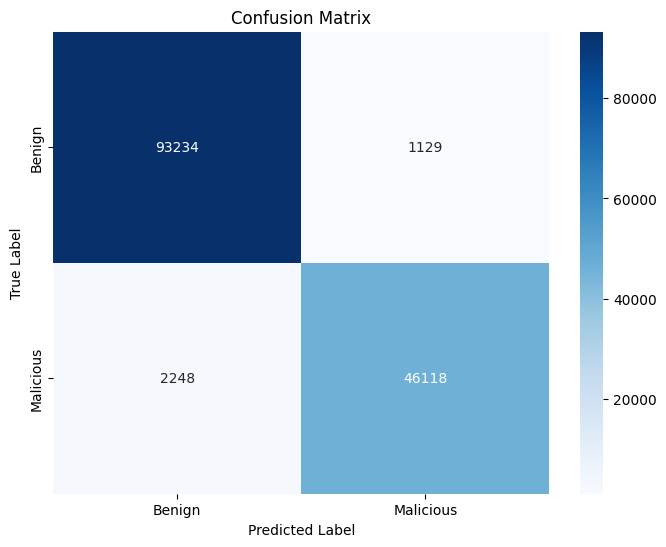

In [10]:
## Cell 9: Visualize Results - Confusion Matrix

print("\n🤔 Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True, # Show the numbers in the cells
    fmt='d',    # Format numbers as integers
    cmap='Blues',
    xticklabels=['Benign', 'Malicious'],
    yticklabels=['Benign', 'Malicious']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

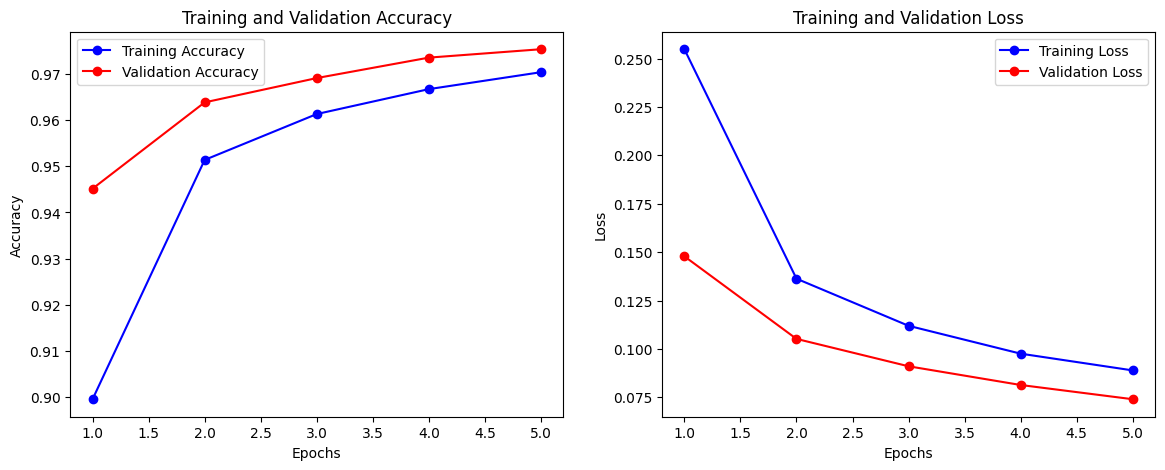

In [11]:
## Cell 10: Visualize Training History

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
## Cell 11: Real-Time Prediction Function (UPDATED)

def predict_threat(payload_string):
    """
    Takes a raw string, preprocesses it, and predicts if it's a threat.
    Uses the same tokenizer that was fitted only on training data.
    """
    # Preprocess the new string using the same tokenizer and padding
    seq = tokenizer.texts_to_sequences([payload_string])
    padded_seq = pad_sequences(seq, maxlen=MAX_LEN)

    # Get the prediction probability from the model
    prediction_prob = model.predict(padded_seq, verbose=0)[0][0]

    # Determine the result based on a 0.5 threshold
    verdict = "🚨 THREAT DETECTED 🚨" if prediction_prob > 0.5 else "✅ BENIGN ✅"

    print(f"\nInput: '{payload_string}'")
    print(f"Malicious Probability: {prediction_prob:.4f}")
    print(f"Verdict: {verdict}")

# --- Test with new, unseen samples ---
print("\n🕵️--- Real-Time Threat Detection Test ---")
predict_threat("<script>alert('xss attack');</script>")
predict_threat("1' OR '1'='1'; --")
predict_threat("https://www.google.com/search?q=normal+search")
predict_threat("../../../etc/passwd")


🕵️--- Real-Time Threat Detection Test ---

Input: '<script>alert('xss attack');</script>'
Malicious Probability: 0.9757
Verdict: 🚨 THREAT DETECTED 🚨

Input: '1' OR '1'='1'; --'
Malicious Probability: 0.9999
Verdict: 🚨 THREAT DETECTED 🚨

Input: 'https://www.google.com/search?q=normal+search'
Malicious Probability: 0.9999
Verdict: 🚨 THREAT DETECTED 🚨

Input: '../../../etc/passwd'
Malicious Probability: 0.7985
Verdict: 🚨 THREAT DETECTED 🚨


In [16]:
## Cell 13: Quick Single Prediction (UPDATED)

# Get user input from a prompt
test_payload = input("Enter the payload or URL to test: ")

if test_payload:
    # 1. Preprocess the input string using the tokenizer fitted only on training data
    seq = tokenizer.texts_to_sequences([test_payload])
    padded_seq = pad_sequences(seq, maxlen=MAX_LEN)

    # 2. Get the model's prediction
    prediction_prob = model.predict(padded_seq, verbose=0)[0][0]

    # 3. Determine the verdict
    if prediction_prob > 0.5:
        verdict = "🚨 THREAT DETECTED"
        color = "\033[1;31m"  # Red
    else:
        verdict = "✅ SAFE"
        color = "\033[1;32m"  # Green

    # 4. Display the result
    print("\n--- Analysis Result ---")
    print(f"Input Payload: '{test_payload}'")
    print(f"Malicious Probability: {prediction_prob:.4f}")
    print(f"{color}Verdict: {verdict}\033[0m")
    print("-----------------------")
else:
    print("No input provided. Please enter a payload to analyze.")


--- Analysis Result ---
Input Payload: '; ls -la'
Malicious Probability: 0.1237
Verdict: ✅ SAFE
-----------------------
